# Analyzing Attitudinal Subtexts Evoked by Iterative Adverbs


This notebook analyzes the attitudinal subtexts evoked by sentences containing iterative adverbs *erneut* 'again', *immer wieder* 'again and again', and *schon wieder* 'yet again' attracted from the corpus. This set of sentences is referred to as *iterAdv-S* in the original paper as well as this script. For more details, we refer to Section 4.2 of the original paper.

In [1]:
import torch

# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 3 GPU(s) available.
We will use the GPU: Quadro RTX 5000


In [4]:
import re, random
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from nltk import word_tokenize
from nltk.util import ngrams
from collections import defaultdict, Counter, OrderedDict
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import BertForSequenceClassification, AdamW, BertConfig, get_linear_schedule_with_warmup, BertTokenizer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from scipy.spatial.distance import cosine
from yellowbrick.cluster import SilhouetteVisualizer

In [5]:
df = pd.read_csv("iterAdv-S.tsv", sep="\t", encoding="utf-8")
print(df.shape)
print(df["source"].value_counts())
df.head()

(2254, 5)
0    1139
1     558
2     557
Name: source, dtype: int64


,source,sent,sent_lemmatized,sent_lemmatized_removedKeyExp,sent_lemmatized_removedKeyExp_PVassembled
0,0,Denn in der Nacht krachte es erneut in dem Asy...,Nacht krachen erneut Asylbewerberheim,Nacht krachen Asylbewerberheim,Nacht krachen Asylbewerberheim
1,0,Als die 28-jährige syrische Mutter mir davon e...,28-jährig syrisch Mutter erzählen Drehen unter...,28-jährig syrisch Mutter erzählen Drehen unter...,28-jährig syrisch Mutter erzählen Drehen unter...
2,0,"Man kann nur immer wieder versuchen, sie unsic...",versuchen unsichtbar,versuchen unsichtbar,versuchen unsichtbar
3,0,"Rakers: ""Ja, es gibt immer wieder Momente, in ...",Rakers geben Moment schwer fallen,Rakers geben Moment schwer fallen,Rakers geben Moment schwer fallen
4,0,"Sie fordern erneut Bleiberecht und sagen, dass...",fordern erneut Bleiberecht sagen Benzin Dach,fordern Bleiberecht sagen Benzin Dach,fordern Bleiberecht sagen Benzin Dach


In [6]:
df = df.dropna(subset=['sent_lemmatized_removedKeyExp'])
print(df.shape)
print(df["source"].value_counts())

(2253, 5)
0    1138
1     558
2     557
Name: source, dtype: int64


# 1. Extract BERT Embedding for iterAdv-S 

In [6]:
output_dir = '/finetuned_BERT_on_200wordseqs'

tokenizer = BertTokenizer.from_pretrained(output_dir)

model = BertForSequenceClassification.from_pretrained(
    output_dir, 
    num_labels = 3,  
    output_attentions = False, 
    output_hidden_states = True 
    )
    
model.eval()
model.cuda()

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30000, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [7]:
# Run a sample tokenization on all sequences in the training set to get the max_len
#max_len = 0

#for text in df["sent"]:
 #   text = re.sub("\W+"," ",text)
  #  input_ids = tokenizer.encode(text, 
   #                              add_special_tokens=True)
    #max_len = max(max_len, len(input_ids))

#print('Max sentence length: ', max_len)

Max sentence length:  101


In [8]:
MAX_LEN = 101

In [9]:
all_embeds = []

for idx, text in enumerate(df["sent"]):
    print("Processing #", idx, "...")
    
    text = re.sub("\W+"," ",text)
    
    encoded_dict = tokenizer.encode_plus(
            text,                      # Sentence to encode.
            add_special_tokens = True, # Add '[CLS]' and '[SEP]'
            padding = "max_length",
            truncation = True,
            max_length = MAX_LEN,
            return_attention_mask = True,
            return_tensors = 'pt'
    )
        
    # ----- This block is only for checking the results of tokenization
    #print(text)
    #print(tokenizer.convert_ids_to_tokens(encoded_dict['input_ids'][0])) 
    #print(len(tokenizer.convert_ids_to_tokens(encoded_dict['input_ids'][0])))
    #print("-----") 
    
    input_ids = encoded_dict['input_ids'].to(device)
    attention_masks = encoded_dict['attention_mask'].to(device)
        
    with torch.no_grad():
        outputs = model(input_ids, 
                        token_type_ids=None, 
                        attention_mask=attention_masks)
        hidden_states = outputs[1]
        
    # ----- Get the sequence embedding as the embedding of CLS (first token of each sentence) of the 11th layer -----
    token_vecs = hidden_states[-2][0][0]
        
    all_embeds.append(token_vecs)
    
print("Done.")

Processing # 0 ...
Processing # 1 ...
Processing # 2 ...
Processing # 3 ...
Processing # 4 ...
Processing # 5 ...
Processing # 6 ...
Processing # 7 ...
Processing # 8 ...
Processing # 9 ...
Processing # 10 ...
Processing # 11 ...
Processing # 12 ...
Processing # 13 ...
Processing # 14 ...
Processing # 15 ...
Processing # 16 ...
Processing # 17 ...
Processing # 18 ...
Processing # 19 ...
Processing # 20 ...
Processing # 21 ...
Processing # 22 ...
Processing # 23 ...
Processing # 24 ...
Processing # 25 ...
Processing # 26 ...
Processing # 27 ...
Processing # 28 ...
Processing # 29 ...
Processing # 30 ...
Processing # 31 ...
Processing # 32 ...
Processing # 33 ...
Processing # 34 ...
Processing # 35 ...
Processing # 36 ...
Processing # 37 ...
Processing # 38 ...
Processing # 39 ...
Processing # 40 ...
Processing # 41 ...
Processing # 42 ...
Processing # 43 ...
Processing # 44 ...
Processing # 45 ...
Processing # 46 ...
Processing # 47 ...
Processing # 48 ...
Processing # 49 ...
Processing

In [10]:
df.insert(5, "bert_emb", all_embeds)
print(df.shape)
print(df["source"].value_counts())
df.head()

(2253, 6)
0    1138
1     558
2     557
Name: source, dtype: int64


,source,sent,sent_lemmatized,sent_lemmatized_removedKeyExp,sent_lemmatized_removedKeyExp_PVassembled,bert_emb
0,0,Denn in der Nacht krachte es erneut in dem Asy...,Nacht krachen erneut Asylbewerberheim,Nacht krachen Asylbewerberheim,Nacht krachen Asylbewerberheim,"[tensor(-0.1581, device='cuda:0'), tensor(-0.4..."
1,0,Als die 28-jährige syrische Mutter mir davon e...,28-jährig syrisch Mutter erzählen Drehen unter...,28-jährig syrisch Mutter erzählen Drehen unter...,28-jährig syrisch Mutter erzählen Drehen unter...,"[tensor(1.1769, device='cuda:0'), tensor(-0.35..."
2,0,"Man kann nur immer wieder versuchen, sie unsic...",versuchen unsichtbar,versuchen unsichtbar,versuchen unsichtbar,"[tensor(0.2407, device='cuda:0'), tensor(-0.59..."
3,0,"Rakers: ""Ja, es gibt immer wieder Momente, in ...",Rakers geben Moment schwer fallen,Rakers geben Moment schwer fallen,Rakers geben Moment schwer fallen,"[tensor(0.4199, device='cuda:0'), tensor(-0.74..."
4,0,"Sie fordern erneut Bleiberecht und sagen, dass...",fordern erneut Bleiberecht sagen Benzin Dach,fordern Bleiberecht sagen Benzin Dach,fordern Bleiberecht sagen Benzin Dach,"[tensor(-0.1956, device='cuda:0'), tensor(-1.3..."


In [11]:
df.to_pickle("iterAdv-S_with_BERT_emb.pkl")

# 2. K-Means Clustering

In [5]:
df_bert = pd.read_pickle("iterAdv-S_with_BERT_emb")
print(df_bert.shape)
print(df_bert["source"].value_counts())
df_bert.head()

(2253, 6)
0    1138
1     558
2     557
Name: source, dtype: int64


,source,sent,sent_lemmatized,sent_lemmatized_removedKeyExp,sent_lemmatized_removedKeyExp_PVassembled,bert_emb
0,0,Denn in der Nacht krachte es erneut in dem Asy...,Nacht krachen erneut Asylbewerberheim,Nacht krachen Asylbewerberheim,Nacht krachen Asylbewerberheim,"[tensor(-0.1581, device='cuda:0'), tensor(-0.4..."
1,0,Als die 28-jährige syrische Mutter mir davon e...,28-jährig syrisch Mutter erzählen Drehen unter...,28-jährig syrisch Mutter erzählen Drehen unter...,28-jährig syrisch Mutter erzählen Drehen unter...,"[tensor(1.1769, device='cuda:0'), tensor(-0.35..."
2,0,"Man kann nur immer wieder versuchen, sie unsic...",versuchen unsichtbar,versuchen unsichtbar,versuchen unsichtbar,"[tensor(0.2407, device='cuda:0'), tensor(-0.59..."
3,0,"Rakers: ""Ja, es gibt immer wieder Momente, in ...",Rakers geben Moment schwer fallen,Rakers geben Moment schwer fallen,Rakers geben Moment schwer fallen,"[tensor(0.4199, device='cuda:0'), tensor(-0.74..."
4,0,"Sie fordern erneut Bleiberecht und sagen, dass...",fordern erneut Bleiberecht sagen Benzin Dach,fordern Bleiberecht sagen Benzin Dach,fordern Bleiberecht sagen Benzin Dach,"[tensor(-0.1956, device='cuda:0'), tensor(-1.3..."


## 2.1 Get optimal Cluster Amount of Each Newspaper

In [5]:
bild_emb = [i.cpu().numpy() for i in df_bert.loc[df_bert["source"]==0, "bert_emb"].values]
faz_emb = [i.cpu().numpy() for i in df_bert.loc[df_bert["source"]==1, "bert_emb"].values]
sz_emb = [i.cpu().numpy() for i in df_bert.loc[df_bert["source"]==2, "bert_emb"].values]

### BILD:

Clustering into 2 groups
Clustering into 3 groups
Clustering into 4 groups
Clustering into 5 groups
Clustering into 6 groups
Clustering into 7 groups
Clustering into 8 groups
Clustering into 9 groups
Clustering into 10 groups
Clustering into 11 groups
Clustering into 12 groups
Clustering into 13 groups
Clustering into 14 groups
Clustering into 15 groups
Clustering into 16 groups
Clustering into 17 groups
Clustering into 18 groups
Clustering into 19 groups
Clustering into 20 groups
Clustering into 21 groups
Clustering into 22 groups
Clustering into 23 groups
Clustering into 24 groups
Clustering into 25 groups
Clustering into 26 groups
Clustering into 27 groups
Clustering into 28 groups
Clustering into 29 groups
Clustering into 30 groups
Clustering into 31 groups
Clustering into 32 groups
Clustering into 33 groups
Clustering into 34 groups
Clustering into 35 groups
Clustering into 36 groups
Clustering into 37 groups
Clustering into 38 groups
Clustering into 39 groups
Clustering into 40 g

Text(0, 0.5, 'Sum of squared distances')

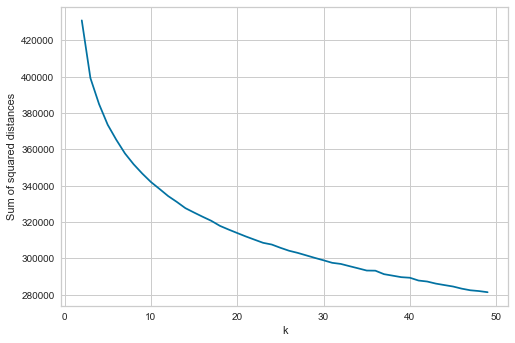

In [15]:
%%time

ssd = []
K = range(2,50)
for k in K:
    print("Clustering into {} groups".format(k))
    km = KMeans(n_clusters=k, n_init=100, max_iter=2000)
    km = km.fit(bild_emb)
    ssd.append(km.inertia_)

plt.figure()
plt.plot(K, ssd, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum of squared distances')

1 0
1 1
2 0
2 1


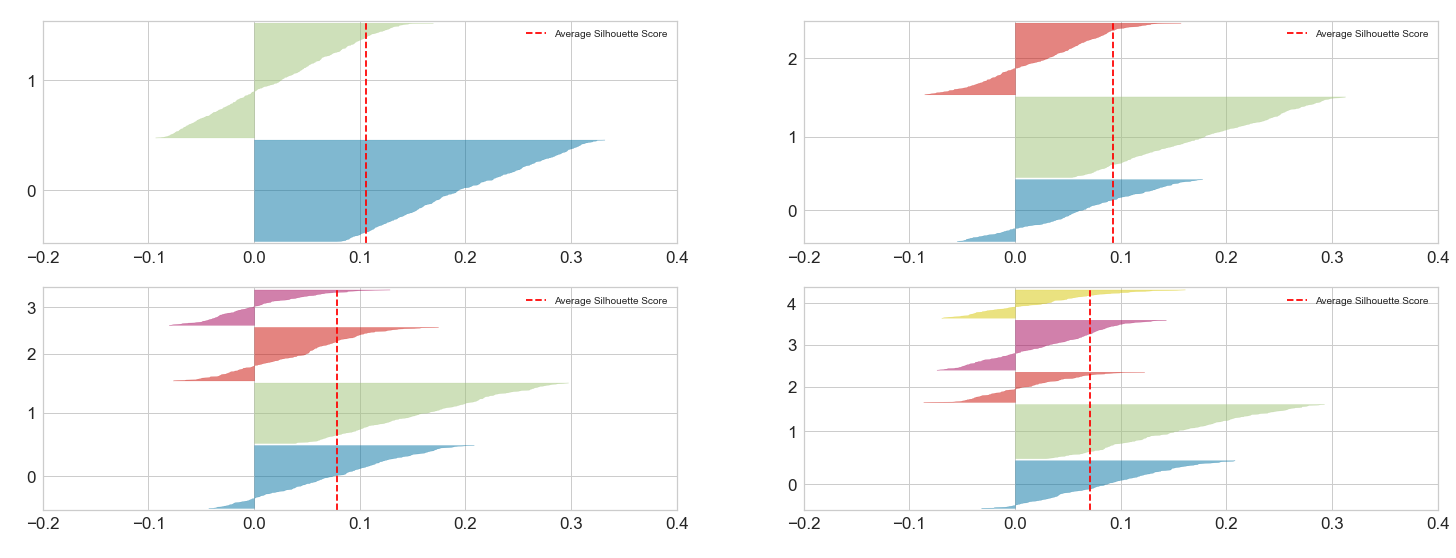

In [53]:
fig, ax = plt.subplots(2, 2, figsize=(25,9)) 

for i in range(2, 6):
    '''
    Create KMeans instance for different number of clusters
    '''
    km = KMeans(n_clusters=i, init='k-means++', n_init=100, max_iter=2000, random_state=42)
    q, mod = divmod(i, 2)
    print(q, mod)
    '''
    Create SilhouetteVisualizer instance with KMeans instance
    Fit the visualizer
    '''
    ax[q-1][mod].tick_params(axis='x', labelsize=17)
    ax[q-1][mod].tick_params(axis='y', labelsize=17)
    ax[q-1][mod].set_xlabel('xlabel', fontsize=17) 
    ax[q-1][mod].set_ylabel('xlabel', fontsize=17)
    
    visualizer = SilhouetteVisualizer(km, colors='yellowbrick', ax=ax[q-1][mod])
    visualizer.fit(np.asarray(bild_emb))
    visualizer.finalize()
    
    custom_viz = visualizer.ax
    custom_viz.set_title(" ")
    custom_viz.set_xlabel(" ")
    custom_viz.set_ylabel(" ")
    
plt.savefig("bild_silhoette.png", dpi=350, bbox_inches="tight")

### FAZ:

Clustering into 2 groups
Clustering into 3 groups
Clustering into 4 groups
Clustering into 5 groups
Clustering into 6 groups
Clustering into 7 groups
Clustering into 8 groups
Clustering into 9 groups
Clustering into 10 groups
Clustering into 11 groups
Clustering into 12 groups
Clustering into 13 groups
Clustering into 14 groups
Clustering into 15 groups
Clustering into 16 groups
Clustering into 17 groups
Clustering into 18 groups
Clustering into 19 groups
Clustering into 20 groups
Clustering into 21 groups
Clustering into 22 groups
Clustering into 23 groups
Clustering into 24 groups
Clustering into 25 groups
Clustering into 26 groups
Clustering into 27 groups
Clustering into 28 groups
Clustering into 29 groups
Clustering into 30 groups
Clustering into 31 groups
Clustering into 32 groups
Clustering into 33 groups
Clustering into 34 groups
Clustering into 35 groups
Clustering into 36 groups
Clustering into 37 groups
Clustering into 38 groups
Clustering into 39 groups
Clustering into 40 g

Text(0, 0.5, 'Sum of squared distances')

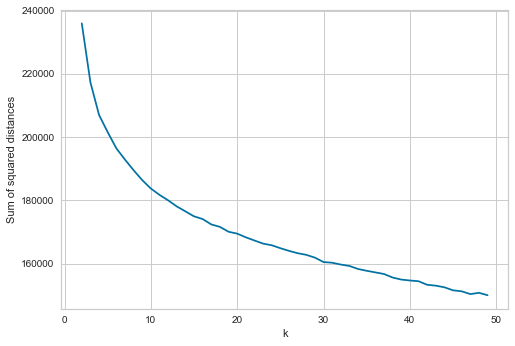

In [24]:
%%time

ssd = []
K = range(2,50)
for k in K:
    print("Clustering into {} groups".format(k))
    km = KMeans(n_clusters=k, n_init=100, max_iter=2000)
    km = km.fit(faz_emb)
    ssd.append(km.inertia_)

plt.figure()
plt.plot(K, ssd, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum of squared distances')

1 0
1 1
2 0
2 1


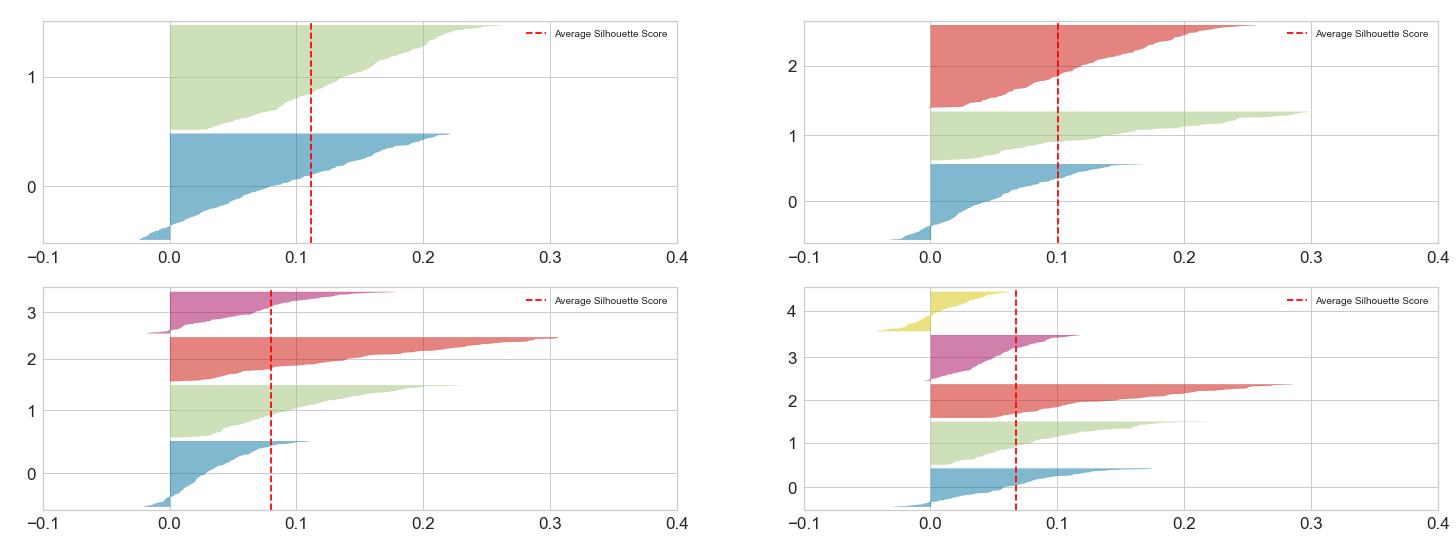

In [54]:
fig, ax = plt.subplots(2, 2, figsize=(25,9))

for i in range(2, 6):
    km = KMeans(n_clusters=i, init='k-means++', n_init=100, max_iter=2000, random_state=42)
    q, mod = divmod(i, 2)
    print(q, mod)

    ax[q-1][mod].tick_params(axis='x', labelsize=17)
    ax[q-1][mod].tick_params(axis='y', labelsize=17)
    ax[q-1][mod].set_xlabel('xlabel', fontsize=17) 
    ax[q-1][mod].set_ylabel('xlabel', fontsize=17)
    
    visualizer = SilhouetteVisualizer(km, colors='yellowbrick', ax=ax[q-1][mod])
    visualizer.fit(np.asarray(faz_emb))
    visualizer.finalize()
    
    custom_viz = visualizer.ax
    custom_viz.set_title(" ")
    custom_viz.set_xlabel(" ")
    custom_viz.set_ylabel(" ")
    
plt.savefig("faz_silhoette.png", dpi=350, bbox_inches="tight")

### SZ:

Clustering into 2 groups
Clustering into 3 groups
Clustering into 4 groups
Clustering into 5 groups
Clustering into 6 groups
Clustering into 7 groups
Clustering into 8 groups
Clustering into 9 groups
Clustering into 10 groups
Clustering into 11 groups
Clustering into 12 groups
Clustering into 13 groups
Clustering into 14 groups
Clustering into 15 groups
Clustering into 16 groups
Clustering into 17 groups
Clustering into 18 groups
Clustering into 19 groups
Clustering into 20 groups
Clustering into 21 groups
Clustering into 22 groups
Clustering into 23 groups
Clustering into 24 groups
Clustering into 25 groups
Clustering into 26 groups
Clustering into 27 groups
Clustering into 28 groups
Clustering into 29 groups
Clustering into 30 groups
Clustering into 31 groups
Clustering into 32 groups
Clustering into 33 groups
Clustering into 34 groups
Clustering into 35 groups
Clustering into 36 groups
Clustering into 37 groups
Clustering into 38 groups
Clustering into 39 groups
Clustering into 40 g

Text(0, 0.5, 'Sum of squared distances')

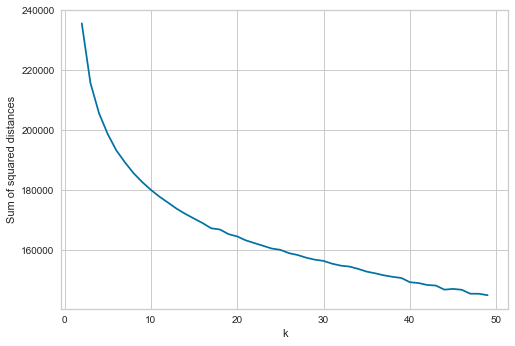

In [31]:
%%time

ssd = []
K = range(2,50)
for k in K:
    print("Clustering into {} groups".format(k))
    km = KMeans(n_clusters=k, n_init=100, max_iter=2000)
    km = km.fit(sz_emb)
    ssd.append(km.inertia_)

plt.figure()
plt.plot(K, ssd, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum of squared distances')

1 0
1 1
2 0
2 1


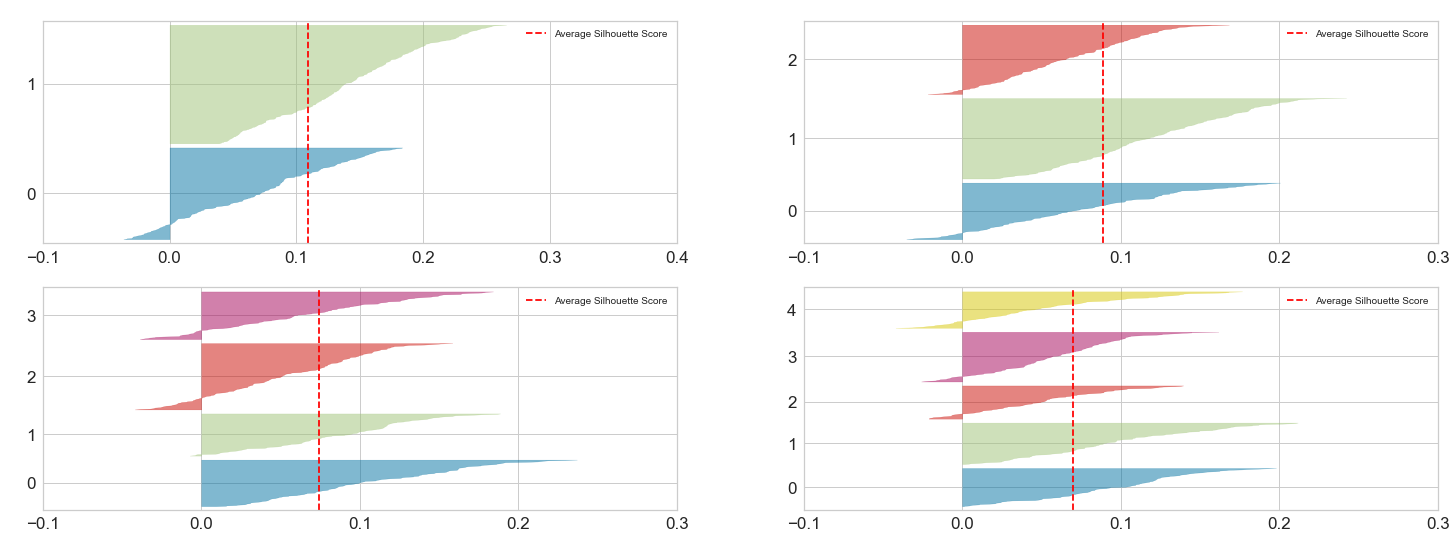

In [55]:
fig, ax = plt.subplots(2, 2, figsize=(25,9))

for i in range(2, 6):
    km = KMeans(n_clusters=i, init='k-means++', n_init=100, max_iter=2000, random_state=42)
    q, mod = divmod(i, 2)
    print(q, mod)

    ax[q-1][mod].tick_params(axis='x', labelsize=17)
    ax[q-1][mod].tick_params(axis='y', labelsize=17)
    ax[q-1][mod].set_xlabel('xlabel', fontsize=17) 
    ax[q-1][mod].set_ylabel('xlabel', fontsize=17)
    
    visualizer = SilhouetteVisualizer(km, colors='yellowbrick', ax=ax[q-1][mod])
    visualizer.fit(np.asarray(sz_emb))
    visualizer.finalize()
    
    custom_viz = visualizer.ax
    custom_viz.set_title(" ")
    custom_viz.set_xlabel(" ")
    custom_viz.set_ylabel(" ")
    
plt.savefig("sz_silhoette.png", dpi=350, bbox_inches="tight")

## 2.2 Clustering *iterAdv-S* Using Optimal Cluster Amount

In [6]:
def get_cluster_result(df, label, n_clusters):
    """
    Cluster the iterAdv-S. 
    
    Parameters
    ----------
    df: Dataframe with BERT-embeddings of the iterAdv-S.
    label: The newspaper to be clustered.
    n_clusters: The amount of cluster.
    """
    embs = [i.cpu().numpy() for i in df.loc[df["source"]==label, "bert_emb"].values]
    km = KMeans(n_clusters=n_clusters, n_init=100, max_iter=2000, random_state=42)
    km.fit(embs)
    clusters = km.labels_.tolist()
    cluster_centers = km.cluster_centers_
    
    df_cluster = pd.DataFrame({"sentence": df.loc[df["source"]==label, "sent"], 
                               "sent_lemmatized_removedKeyExp": df.loc[df["source"]==label, "sent_lemmatized_removedKeyExp"],
                               "sent_lemmatized_removedKeyExp_PVassembled": df.loc[df["source"]==label, "sent_lemmatized_removedKeyExp_PVassembled"], 
                               "sent_emb": embs, 
                               "cluster": clusters})
    
    all_cos_sim = []
    for idx, row in df_cluster.iterrows():
        cos_sim = cosine(np.array(row.sent_emb), cluster_centers[row.cluster])
        all_cos_sim.append(cos_sim)
    df_cluster.insert(4, "cossim_to_centroid", all_cos_sim)
    
    return df_cluster

In [7]:
def get_pmi_freq_dict_for_cluster(df, label, n, calculation):
    """
    Get PMI-freq scores of each n-gram in each cluster of each newspaper.
    
    Parameters
    ----------
    df: Dataframe of iterAdv-S.
    label: The label of the cluster to be checked.
    n: The n-value (i.e., length) of n-grams.
    calculation: When setted to "pmi-freq", PMI-freq will be calculated. When setted to "pmi", PMI will be calculated.
    """
    
    # ----- Get doc_freq(x) -----
    doc_freq_dict = defaultdict(int)
    for t in df["sent_lemmatized_removedKeyExp_PVassembled"]:
        tokens = [" ".join(i) for i in ngrams(word_tokenize(t, language="german"), n)]
        for w in set(tokens):
            doc_freq_dict[w] += 1
            
    # ----- Get p(x) -----
    prob_x_dict = defaultdict(int)
    total_token_count = 0
    for index, row in df.iterrows(): 
        tokens = [" ".join(i) for i in ngrams(word_tokenize(row["sent_lemmatized_removedKeyExp_PVassembled"], language="german"), n)]
        total_token_count += len(tokens)
        for t in tokens:
            prob_x_dict[t] += 1
            
    for k, v in prob_x_dict.items():
        prob_x_dict[k] = v / total_token_count
        
    # ----- Get p(x|y) -----
    prob_x_y_dict = defaultdict(int)
    current_df = df.loc[df["cluster"]==label, ]
    current_df_token_count = 0
    
    for idx, row in current_df.iterrows():
        tokens = [" ".join(i) for i in ngrams(word_tokenize(row["sent_lemmatized_removedKeyExp_PVassembled"], language="german"), n)]
        for t in tokens:
            prob_x_y_dict[t] += 1
            current_df_token_count += 1
                
    label_prob = current_df_token_count/total_token_count # p(y)
    for k, v in prob_x_y_dict.items():
        prob_x_y_dict[k] = v/total_token_count/label_prob # p(x|y) = p(x,y)/p(y)
    
    # ----- Get result dict -----
    pmi_dict = defaultdict(float)
    pmi_freq_dict = defaultdict(float)
    
    words = []
    for sent in df.loc[df["cluster"]==label, ]["sent_lemmatized_removedKeyExp_PVassembled"]: 
        for ngram in [" ".join(i) for i in ngrams(word_tokenize(sent, language="german"), n)]:
            words.append(ngram)
            
    for word in words:
        pmi_dict[word] = np.log(prob_x_y_dict[word]/prob_x_dict[word])
        pmi_freq_dict[word] =  np.log(doc_freq_dict[word]) * np.log(prob_x_y_dict[word] / prob_x_dict[word])
   
    if calculation == "pmi":
        return {k: v for k, v in sorted(pmi_dict.items(), key=lambda item: item[1], reverse=True)} 
    if calculation == "pmi-freq":
        return {k: v for k, v in sorted(pmi_freq_dict.items(), key=lambda item: item[1], reverse=True)} ###
        # return {k: v for k, v in sorted(pmi_freq_dict.items(), key=lambda item: item[1], reverse=True)}, doc_freq_dict ###

In [8]:
df_cluster_bild = get_cluster_result(df_bert, label=0, n_clusters=3)
print(df_cluster_bild.shape)
print(df_cluster_bild["cluster"].value_counts())
df_cluster_bild.head()

(1138, 6)
1    428
2    381
0    329
Name: cluster, dtype: int64


,sentence,sent_lemmatized_removedKeyExp,sent_lemmatized_removedKeyExp_PVassembled,sent_emb,cossim_to_centroid,cluster
0,Denn in der Nacht krachte es erneut in dem Asy...,Nacht krachen Asylbewerberheim,Nacht krachen Asylbewerberheim,"[-0.15806383, -0.46344954, -0.57085735, 1.2205...",0.074484,1
1,Als die 28-jährige syrische Mutter mir davon e...,28-jährig syrisch Mutter erzählen Drehen unter...,28-jährig syrisch Mutter erzählen Drehen unter...,"[1.1769441, -0.35239935, -0.42033565, 0.421386...",0.217683,1
2,"Man kann nur immer wieder versuchen, sie unsic...",versuchen unsichtbar,versuchen unsichtbar,"[0.24070683, -0.5899871, -1.2045387, -0.922411...",0.148695,2
3,"Rakers: ""Ja, es gibt immer wieder Momente, in ...",Rakers geben Moment schwer fallen,Rakers geben Moment schwer fallen,"[0.4199359, -0.74166393, 0.39550534, 0.3143341...",0.242407,1
4,"Sie fordern erneut Bleiberecht und sagen, dass...",fordern Bleiberecht sagen Benzin Dach,fordern Bleiberecht sagen Benzin Dach,"[-0.19555746, -1.362397, -1.2470657, -0.099514...",0.184588,0


In [9]:
df_cluster_faz = get_cluster_result(df_bert, label=1, n_clusters=3)
print(df_cluster_faz.shape)
print(df_cluster_faz["cluster"].value_counts())
df_cluster_faz.head()

(558, 6)
2    223
0    204
1    131
Name: cluster, dtype: int64


,sentence,sent_lemmatized_removedKeyExp,sent_lemmatized_removedKeyExp_PVassembled,sent_emb,cossim_to_centroid,cluster
1139,"Sieben lange Tage dauerte die Überfahrt, weil ...",lang Tag daueren überfahrt überlastet Bootsmot...,lang Tag daueren überfahrt überlastet Bootsmot...,"[1.4193716, -0.241269, -1.838594, -1.2511663, ...",0.231354,2
1140,Immer wieder werden ihm nun vor allem drei Fra...,Frage stellen Flüchtling Schweden erster,Frage stellen Flüchtling Schweden erster,"[1.7305167, -0.81678367, -0.7446354, -1.928825...",0.239950,0
1141,Immer wieder hat sie das schon in Stockholm vo...,Stockholm vortragen Schweden Großzügigkeit Gro...,Stockholm vortragen Schweden Großzügigkeit Gro...,"[-0.81011987, -0.014906426, -1.4175615, 0.2052...",0.310314,0
1142,Enthüllungen über fremdenfeindliche Aussetzer ...,Enthüllung fremdenfeindlich Aussetzer Partei g...,Enthüllung fremdenfeindlich Aussetzer Partei g...,"[0.5756001, -1.988116, -0.21084248, -0.2160143...",0.247222,2
1143,Immer wieder fliegen Steine.,fliegen Stein,fliegen Stein,"[0.41587216, -1.415466, -1.5524703, -0.1826474...",0.213352,2


In [10]:
df_cluster_sz = get_cluster_result(df_bert, label=2, n_clusters=3)
print(df_cluster_sz.shape)
print(df_cluster_sz["cluster"].value_counts())
df_cluster_sz.head()

(557, 6)
1    217
2    187
0    153
Name: cluster, dtype: int64


,sentence,sent_lemmatized_removedKeyExp,sent_lemmatized_removedKeyExp_PVassembled,sent_emb,cossim_to_centroid,cluster
1697,"Scholz verteidigt sich, immer wieder.",Scholz verteidigen,Scholz verteidigen,"[-0.88904077, -1.76764, -0.99237263, -0.297519...",0.266372,1
1698,Allein in den vergangenen Tagen haben Küstenwa...,vergangen Tag Küstenwache Marine Mensch Bord S...,vergangen Tag Küstenwache Marine Mensch Bord S...,"[0.65809, -0.8150202, -0.89244884, -0.721469, ...",0.191854,0
1699,Schon diese bunt bemalten Kähne waren selten i...,bunt bemalt Kahn selten seetüchtig Zustand Tod...,bunt bemalt Kahn selten seetüchtig Zustand Tod...,"[-0.15394887, -1.9616051, -1.3050679, 0.246821...",0.172721,2
1700,Die Regierung von Mittelfranken hat angekündig...,Regierung Mittelfranken ankündigen Urteil Amts...,Regierung Mittelfranken ankündigen Urteil Amts...,"[0.64416033, -0.014234206, -0.9730674, 0.18537...",0.508472,1
1701,Denn das Bundesamt für Migration und Flüchtlin...,Bundesamt Migration Flüchtling gerade monatlic...,Bundesamt Migration Flüchtling gerade monatlic...,"[1.6474528, -2.0332742, -0.9283176, 0.19327557...",0.431955,1


# 3. Plot

In [74]:
def get_plot(df, ngram, top_n, save_path, barcolor, xlim):
    """
    Plot the top N words of a cluster together with their PMI-freq values.
    
    Parameters
    ----------
    df: Dataframe with clustering results.
    ngram: The length of the items to be plotted. See method "get_pmi_freq_dict_for_cluster()" for details.  
    top_n: The amount of words to be plotted. 
    save_path: Path to save the plot.  
    barcolor: Color of the bar for PMI-freq scores.
    xlim: The limit of the x-axis.  
    """
    clusters = list(df["cluster"].value_counts().index)
    fig, axs = plt.subplots(1, len(clusters), figsize=(25, 13), sharex=True)
    fig.tight_layout(pad=22.0)
    col = 0
    
    for c in clusters:
        pmi_freq_dict = get_pmi_freq_dict_for_cluster(df, label=c, n=ngram, calculation="pmi-freq")
        
        top_n_val = set()
        for k, v in pmi_freq_dict.items():
            top_n_val.add(round(v, 4))
            if len(top_n_val) > top_n - 1:
                break
                
        reversed_dict = {}
        linebreak_point = 6 # When setted as N: A line break will be set after the N-th word, in order to avoid too long ticks. 
        for v in top_n_val:
            items = []
            for k in pmi_freq_dict.keys():
                if round(pmi_freq_dict[k], 4) == v:
                    items.append(k)
            
            if len(items) > linebreak_point:
                reversed_dict[v] = ", ".join(items[:linebreak_point]) + "\n" + ", ".join(items[linebreak_point:])
            else:
                reversed_dict[v] = ", ".join(items)
        
        reversed_dict = OrderedDict(sorted(reversed_dict.items()))
        
        rects = axs[col].barh(list(reversed_dict.values()), list(reversed_dict.keys()), color=barcolor, align='center') #height=0.9 
        
        axs[col].set_xlim([0, xlim])     
        axs[col].set(xlabel="Cluster #" + str(c+1) + " (" + str(df["cluster"].value_counts()[c]) + " samples)")
        plt.savefig(save_path, dpi=350, bbox_inches="tight")
        col += 1

## BILD:

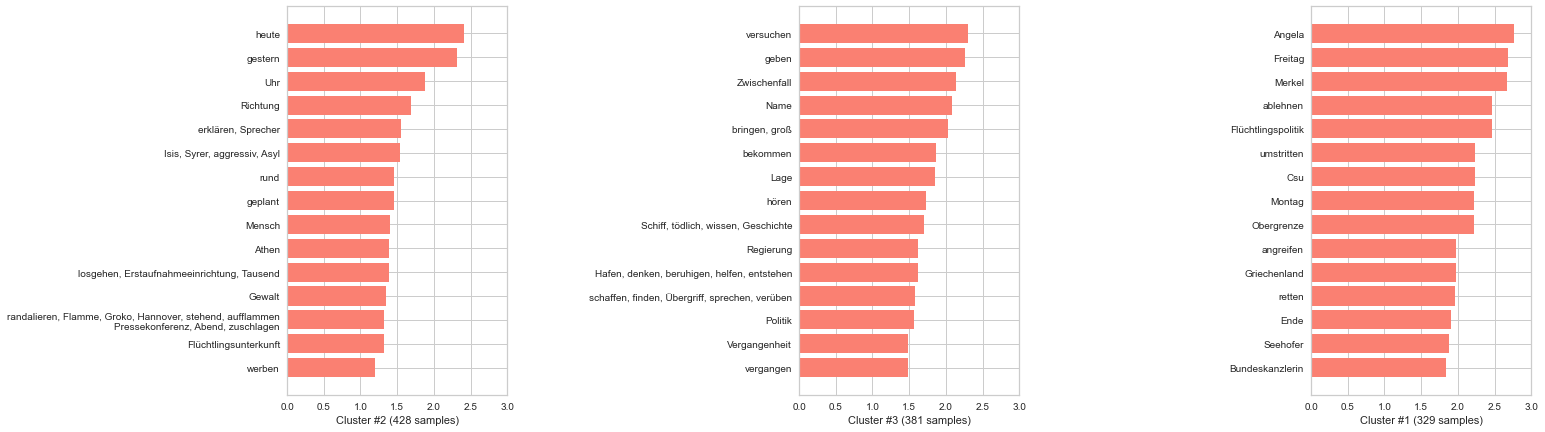

In [64]:
get_plot(df=df_cluster_bild, ngram=1, top_n=15, save_path='/work/qi.yu/output/presup/bild_de.png', barcolor="salmon", xlim=3.0)

## FAZ: 

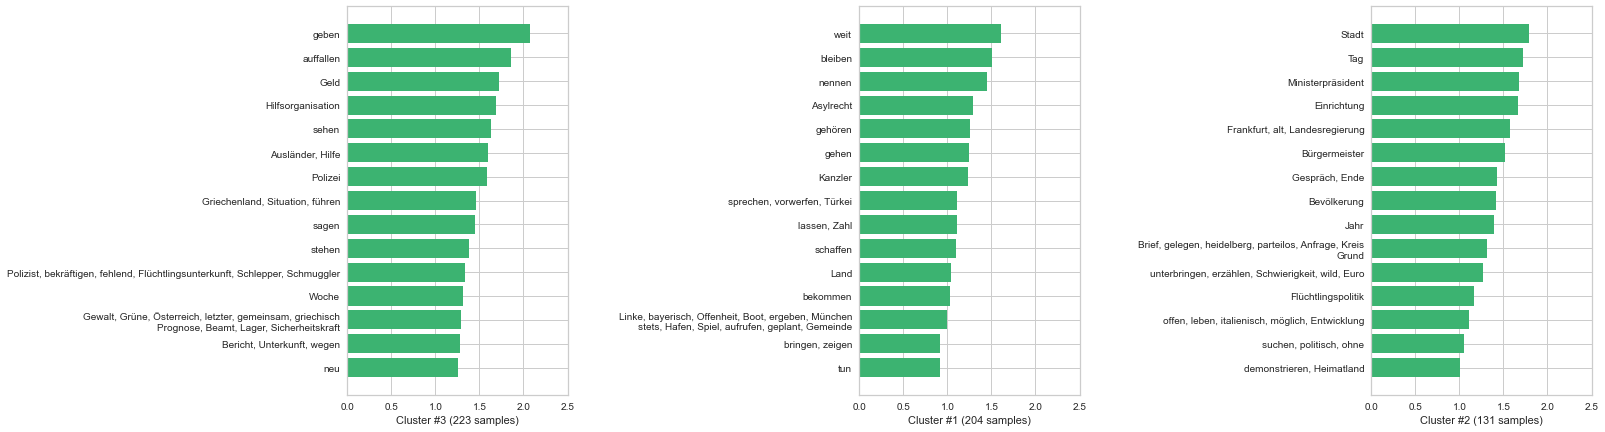

In [68]:
get_plot(df=df_cluster_faz, ngram=1, top_n=15, save_path='/work/qi.yu/output/presup/faz_de.png', barcolor="mediumseagreen", xlim=2.5)

## SZ: 

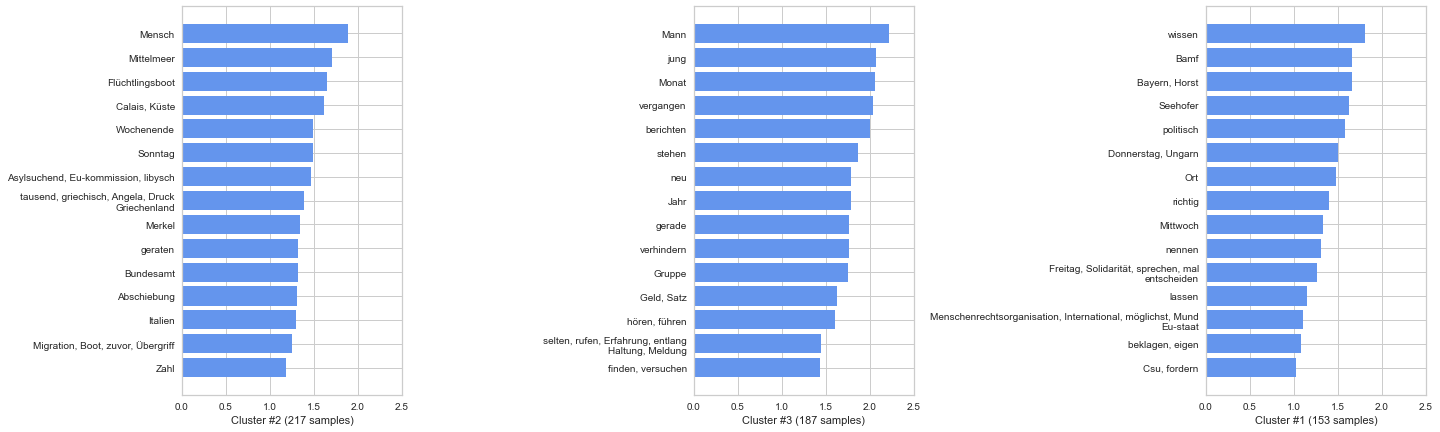

In [75]:
get_plot(df=df_cluster_sz, ngram=1, top_n=15, save_path='/work/qi.yu/output/presup/sz_de.png', barcolor="cornflowerblue", xlim=2.5)